# Retrieval Augmented Generation (RAG) System Using Llama2 With Hugging Face

In [1]:
# !pip install transformers einops langchain bitsandbytes accelerate sentence_transformers chromadb xformers -U
# !pip install llama_index llama-index-core llama-index-readers-file llama-index-llms-ollama llama-index-llms-huggingface llama-index-vector-stores-chroma llama-index-embeddings-huggingface -U
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 

## Import Libraries

In [1]:
import os
import torch
import matplotlib.pyplot as plt
from transformers import BitsAndBytesConfig
from llama_index.core import Settings, VectorStoreIndex, SimpleDirectoryReader, \
    ServiceContext, StorageContext, load_index_from_storage, get_response_synthesizer
from llama_index.core.prompts import PromptTemplate
from llama_index.core.response.pprint_utils import pprint_response
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor
from llama_index.core.node_parser import  SentenceSplitter
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
# from llama_index.vector_stores.chroma import ChromaVectorStore
# import chromadb
# from llama_index.readers.file import FlatReader
from dotenv import load_dotenv
load_dotenv()
# os.environ['HUGGINGFACE_API_KEY']=os.getenv("HUGGINGFACE_API_KEY")
# from huggingface_hub import login
# login(token = os.environ.get("HUGGINGFACE_API_KEY"))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

## Parameter Initialization

In [3]:
LLM_NAME = "meta-llama/Llama-2-7b-chat-hf"              # LLM model path from huggingface
TOKENIZER_NAME = "meta-llama/Llama-2-7b-chat-hf"        # Tokenizer path from huggingface
EMBED_MODEL_ID = "BAAI/bge-small-en-v1.5"               # Embedding model path from huggingface
# INPUT_DATA = './data/materials.md'                      # Path to the input data
INPUT_DATA_PATH = './material'                      # Path to the input data
QUESTION_LIST_PATH = './data/question_context.csv'      # Path to the question list
# VECTOR_STORE_DIR = "./storage"                          # Path to the vector store directory
VECTOR_STORE_DIR = "./vectorDB"                         # Path to the vector store directory
# CHROMA_DB_DIR = "./chroma_db"                           # Path to the chroma db directory
CHUNK_SIZE = 256                                        # Chunk size for the vector store
OVERLAP_SIZE = 10                                       # Overlap size for the vector store
SYSTEM_PROMPT="""
You are an AI teaching Assistant for the SEP 775 course. 
You will provide an interactive platform for students to ask questions and receive guidance on course materials.
Your goal is to answer questions as accurately as possible based on the instructions and context provided.
If you found the answer based on the context provided, you should provide the answer first, then at the end, beginning a new sentence with the words "Source:", followed by the name of the lecture, or assignment, or paper if possible.
"""                                                     # create the instruction prompt                  

## Llama-2 Large Language Model (LLM) from Huggingface

In [4]:
query_wrapper_prompt = PromptTemplate(
    "[INST]<<SYS>>\n" + SYSTEM_PROMPT  + "<</SYS>>\n\n{query_str}[/INST]"
)

# ## Default format supportable by LLama2
# query_wrapper_prompt=SimpleInputPrompt("<|USER|>{query_str}<|ASSISTANT|>")

# quantize to save memory
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,                                  # load in 4 bit
    bnb_4bit_compute_dtype=torch.float16,               # compute in float16
    bnb_4bit_quant_type="nf4",                          # quantize to 4 bit
    bnb_4bit_use_double_quant=True,                     # use double quantization
)

# create the LLM
llm = HuggingFaceLLM(
    model_name=LLM_NAME,                                        # model name
    tokenizer_name=TOKENIZER_NAME,                              # tokenizer name
    context_window=3900,                                        # max context window to store tokens
    max_new_tokens=256,                                         # max new tokens to generate
    model_kwargs={"quantization_config": quantization_config},  # quantization config
    generate_kwargs={
        "temperature": 0.3,                                     # randomness of the output
        "top_p": 0.95,                                          # sampling from the most likely p tokens
        "top_k": 50                                             # only sample from the top k tokens
        },
    query_wrapper_prompt=query_wrapper_prompt,                  # query wrapper prompt
    device_map="auto",                                          # use the default device
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Simple Query Testing

In [5]:
response = llm.complete("Could you tell me about the SEP 775 course from McMaster University?")
print(response)

c:\Users\aiden\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\llama\modeling_llama.py:670: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


 Of course! I'd be happy to help you with any questions you have about the SEP 775 course from McMaster University.

SEP 775 is a course offered by the School of the Environment at McMaster University, which focuses on the study of environmental problems and their impact on society. The course covers a wide range of topics, including climate change, biodiversity loss, water pollution, and sustainable development.

Throughout the course, students will learn about the complex interactions between human activities and the environment, and how these interactions can lead to environmental problems. They will also develop skills in critical thinking, problem-solving, and communication, which are essential for addressing environmental challenges.

Some of the key concepts covered in the course include:

* The science of climate change and its impacts on the environment and human societies
* The role of human activities in driving biodiversity loss and ecosystem degradation
* The impact of wat

## Retrieval Augmented Generation (RAG)

### Ingestion of data

In [6]:
# documents = FlatReader().load_data(Path('./testdata/materials.md'))
# documents = SimpleDirectoryReader(input_files=[INPUT_DATA]).load_data()
documents = SimpleDirectoryReader(INPUT_DATA_PATH).load_data()
print("Number of Document:", len(documents))
print("Length of first Document:", len(documents[0].text))

Number of Document: 51
Length of first Document: 38464


In [7]:
documents[21].text

'Summary. This note introduces the field of Natural Language Pro cessing NLP briefly and then discusses word2vec and the funda mental beautiful idea of representing words as low dimensional real valued vectors learned from distributional signal. 1 Introduction to Natural Language Processing Natural language processing is a field of science and engineering focused on the development and study of automatic systems that understand and generate natural that is human languages. 1.1 Humans and language Human languages are communicative devices enabling the effi cient sharing and storage of complex ideas facts and intents. As Manning 2022 argues the complexity of communication enabled by language is a uniquely human intelligence among species. As scientists and engineers interested in the creation and study of intel ligent systems human language is to us both a fascinating object of study after all it has evolved to be learnable and useful and a great enabler for interacting with humans even 

### Embeddings

In [8]:
''' A vector embedding, often just called an embedding, 
is a numerical representation of the semantics, or meaning of your text. 
Two pieces of text with similar meanings will have mathematically similar embeddings, 
even if the actual text is quite different. '''

embed_model = HuggingFaceEmbedding(
    model_name=EMBED_MODEL_ID, 
    max_length=1024,                 # max length of the input
)

### Split Data in Chunks

Node with max length: 1290


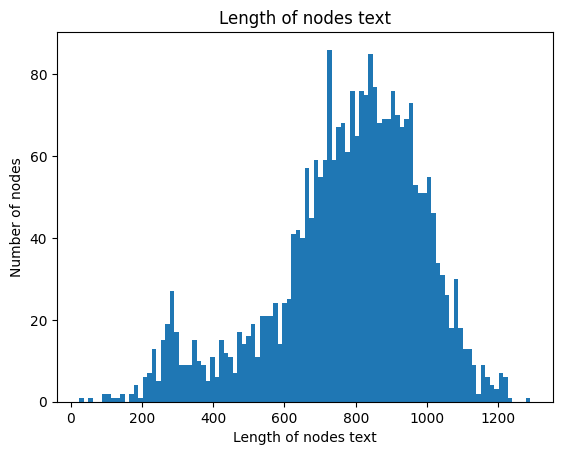

In [9]:
# Create a splitter
splitter = SentenceSplitter(
    chunk_size=CHUNK_SIZE,          # lines per chunk
    chunk_overlap=OVERLAP_SIZE,     # overlap between chunks
)
# get nodes from documents
nodes = splitter.get_nodes_from_documents(documents)

length_nodes = [len(node.text) for node in nodes]

# Get max length of nodes
max_length = max(length_nodes)
print("Node with max length:", max_length)

plt.title('Length of nodes text')
plt.hist(length_nodes, bins=100)
plt.xlabel('Length of nodes text')
plt.ylabel('Number of nodes')
plt.show()

In [10]:
# # create the service context (deprecated)
# service_context = ServiceContext.from_defaults(
#     chunk_size=CHUNK_SIZE,
#     chunk_overlap=OVERLAP_SIZE,
#     llm=llm,
#     embed_model=embed_model
# )

# Settings parameters
Settings.llm = llm
Settings.embed_model = embed_model
Settings.chunk_size = CHUNK_SIZE
Settings.chunk_overlap = OVERLAP_SIZE
# Settings.text_splitter = splitter
# Settings

### Indexing

In [11]:
''' In LlamaIndex terms, an Index is a data structure composed of Document objects, 
designed to enable querying by an LLM. Your Index is designed to be complementary to your querying strategy '''
# # build default index
# index=VectorStoreIndex.from_documents(documents)
# index

# # build index by nodes
# index = VectorStoreIndex(nodes)

' In LlamaIndex terms, an Index is a data structure composed of Document objects, \ndesigned to enable querying by an LLM. Your Index is designed to be complementary to your querying strategy '

### Indexing and Storing to Chroma DB

In [12]:
# # function to get the chroma db and vector store
# def getChromaDB(CHROMA_DB_DIR):
#     # initialize client, setting path to save data
#     db = chromadb.PersistentClient(path=CHROMA_DB_DIR)
#     # create collection
#     chroma_collection = db.get_or_create_collection("quickstart")
#     # assign chroma as the vector_store to the context
#     vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
#     storage_context = StorageContext.from_defaults(vector_store=vector_store)
#     return vector_store, storage_context

# # check if storage already exists
# if not os.path.exists(CHROMA_DB_DIR):
#     print("Creating New DB...")
#     # create the chroma db and vector store
#     vector_store, storage_context = getChromaDB(CHROMA_DB_DIR)
    
#     # create your index
#     index = VectorStoreIndex.from_documents(
#         documents, 
#         storage_context=storage_context,
#         # service_context=service_context, 
#     )
# else:
#     print("Using Existing DB...")
#     # load the chroma db and vector store
#     vector_store, storage_context = getChromaDB(CHROMA_DB_DIR)
    
#     # load your index from stored vectors
#     index = VectorStoreIndex.from_vector_store(
#         vector_store, 
#         storage_context=storage_context,
#         # service_context=service_context,    
#     )

# # create a query engine and query
# query_engine = index.as_query_engine()
# response = query_engine.query("What is NLP")
# print(response)


### Indexing and Storing to Vector Store

In [13]:
# check if storage already exists
if not os.path.exists(VECTOR_STORE_DIR):
    print("Creating New DB...")
    index = VectorStoreIndex.from_documents(documents)
    # index = VectorStoreIndex(nodes)
    # store it for later
    index.storage_context.persist(persist_dir=VECTOR_STORE_DIR)
else:
    print("Using Existing DB...")
    # load the existing index
    storage_context = StorageContext.from_defaults(persist_dir=VECTOR_STORE_DIR)
    index = load_index_from_storage(storage_context=storage_context)

Creating New DB...


### Querying

In [14]:
# # basic method to query the index
# query_engine = index.as_query_engine()

# configure retriever
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=5,
)

# configure postprocessor
postprocessor = SimilarityPostprocessor(
    similarity_cutoff=0.60,
)

# configure response synthesizer
response_synthesizer = get_response_synthesizer()

# assemble query engine
query_engine=RetrieverQueryEngine(
    retriever=retriever, 
    response_synthesizer=response_synthesizer,
    node_postprocessors=[postprocessor],
)

In [15]:
question = "What is the Instructor name of the SEP 775 course?"
response = query_engine.query(question)
print(f"Question: {question}\nAnswer: {response}\n")

Question: What is the Instructor name of the SEP 775 course?
Answer:  Based on the context provided, the Instructor name of the SEP 775 course is Hamidreza Mahyar.

Source: Lecture 01 - Wordvectors1.txt



In [16]:
pprint_response(response,show_source=True)
print(response)

Final Response: Based on the context provided, the Instructor name of
the SEP 775 course is Hamidreza Mahyar.  Source: Lecture 01 -
Wordvectors1.txt
______________________________________________________________________
Source Node 1/5
Node ID: 6c7c5078-07bf-42b6-b968-c404563741ee
Similarity: 0.6858668186338163
Text: Course Outline 1. COURSE INFORMATION Session Offered Winter 2024
Course Name Introduction to Computational Natural Language Processing
Course Code SEP 775 Date s and Time s of lectures Lectures In person
Wednesday 3 30 pm 6 30 pm Program Name System and Technology Calendar
Description This graduate course introduces fundamental concepts in
compu...
______________________________________________________________________
Source Node 2/5
Node ID: 0758a75c-cbeb-449e-95e2-d2d2ffdf7475
Similarity: 0.6634258977411179
Text: COURSE SPECIFICS Course Description This course covers some
fundamental concepts in natural language processing NLP and how they
apply in real world use cases. 

In [17]:
question = "What is the Instructor's email address in the course outline?"
response = query_engine.query(question)
print(f"Question: {question}\nAnswer: {response}\n")

Question: What is the Instructor's email address in the course outline?
Answer:  Based on the information provided in the course outline, the instructor's email address is mahyarh@mcmaster.ca.

Source: NLP Winter 2024 Course Outline.txt



In [18]:
pprint_response(response, show_source=True)
print(response)

Final Response: Based on the information provided in the course
outline, the instructor's email address is mahyarh@mcmaster.ca.
Source: NLP Winter 2024 Course Outline.txt
______________________________________________________________________
Source Node 1/5
Node ID: 1234743f-e69d-4bef-9a8c-38ce22e3951e
Similarity: 0.6762236587193939
Text: . Students should be aware that when they access the electronic
components of a course using these elements private information such
as first and last names user names for the McMaster e mail accounts
and program affiliation may become apparent to all other students in
the same course. The available information is dependent on the
technology use...
______________________________________________________________________
Source Node 2/5
Node ID: c834ef55-7462-4657-9c4a-c834f4917e6d
Similarity: 0.6509078791604194
Text: Regularly check the official University communications channels.
Official University communications are considered received if sent by
pos

In [19]:
question = "What is Assignment 1's deadline?"
response = query_engine.query(question)
print(f"Question: {question}\nAnswer: {response}\n")

Question: What is Assignment 1's deadline?
Answer:  Based on the context provided, Assignment 1's deadline is 35 days from today.

Source: Lecture 1, slide 10



In [20]:
question = "What is BLEU?"
response = query_engine.query(question)
print(f"Question: {question}\nAnswer: {response}\n")

Question: What is BLEU?
Answer:  Based on the context provided, BLEU (Bilingual Evaluation Understudy) is a method for automatic evaluation of machine translation. It is a metric used to measure the quality of machine-generated translations by comparing them to one or several human-written translations. BLEU computes a similarity score based on n-gram precision, usually for 1, 2, 3, and 4 grams, and also includes a penalty for too short system translations. The score ranges from 0 to 1, with higher scores indicating a more accurate translation. BLEU is useful but imperfect, as there are many valid ways to translate a sentence, and a good translation can get a poor BLEU score if it has low n-gram overlap with the human translation.

Source:
Papineni, K., Roukos, S., & Ward, T. (2002). BLEU: A method for automatic evaluation of machine translation. Proceedings of the 40th Annual Meeting of the Association for Computational Linguistics, 311–318. <https://aclweb.org/anthology/P02



### Get all the responses from the question list

In [21]:
# Load question list from csv
import pandas as pd
df = pd.read_csv(QUESTION_LIST_PATH)
df

,Question,Content,Type
0,What is the main focus of the course mentioned...,The main focus of the course is on the tools p...,Lecture
1,What is one of the most successful application...,Machine translation is one of the earliest and...,Lecture
2,What fundamental problem does the note identif...,One fundamental problem in building language-l...,Lecture
3,What does the 'distributional hypothesis' sugg...,The distributional hypothesis suggests that th...,Lecture
4,"According to the note, what major challenge do...",Most existing tools work for precious few (usu...,Lecture
...,...,...,...
225,What is the primary goal of the Open-Retrieval...,"In this work, we introduce the first Open-Retr...",Paper
226,How does ORQA differ from traditional IR syste...,An important aspect of ORQA is its expressivit...,Paper
227,What is the Inverse Cloze Task (ICT) and how d...,"Following this intuition, we propose to pre-tr...",Paper
228,What challenges does ORQA address in open-doma...,We address these challenges by carefully initi...,Paper


In [22]:
# idx = 0
# for question in df['Question']:
#     response = query_engine.query(question)
#     pprint_response(response,show_source=True)
#     print(f"Question: {question}\nAnswer: {response}\n")
#     idx+=1
#     if idx > 5:
#         break 
    

## Evaluation

In [ ]:
import random
from llama_index.core.evaluation import (DatasetGenerator, QueryResponseDataset)

# the number of nodes to evaluate
num_nodes_eval = 2
num_query_eval = 10

# selecting a random sample of nodes
sample_eval_nodes = random.sample(nodes, num_nodes_eval)

# creating our dataset generator
dataset_generator = DatasetGenerator(
    sample_eval_nodes,
    show_progress=True,
    num_questions_per_chunk=1,
)

eval_dataset = await dataset_generator.agenerate_dataset_from_nodes(num=num_query_eval)
eval_dataset.save_json("./data/llama_eval_qr_dataset.json")
eval_dataset = QueryResponseDataset.from_json("./data/llama_eval_qr_dataset.json")

C:\Users\aiden\AppData\Local\Temp\ipykernel_14940\568227846.py:11: DeprecationWarning: Call to deprecated class DatasetGenerator. (Deprecated in favor of `RagDatasetGenerator` which should be used instead.)
  dataset_generator = DatasetGenerator(






100%|██████████| 2/2 [00:05<00:00,  2.83s/it]










100%|██████████| 5/5 [00:02<00:00,  2.13it/s]












100%|██████████| 6/6 [00:01<00:00,  4.07it/s]
c:\Users\aiden\AppData\Local\Programs\Python\Python310\lib\site-packages\llama_index\core\evaluation\dataset_generation.py:309: DeprecationWarning: Call to deprecated class QueryResponseDataset. (Deprecated in favor of `LabelledRagDataset` which should be used instead.)
  return QueryResponseDataset(queries=queries, responses=responses_dict)
c:\Users\aiden\AppData\Local\Programs\Python\Python310\lib\site-packages\llama_index\core\evaluation\dataset_generation.py:109: DeprecationWarning: Call to deprecated class QueryResponseDataset. (Deprecated in favor of `LabelledRagDataset` whi

In [ ]:
eval_dataset.responses

[('What did Britz et al. find regarding the optimal number of layers for the encoder and decoder RNNs in their 2017 paper on Neural Machine Translation?',
  'Britz et al. found that for Neural Machine Translation in their 2017 paper, 2 to 4 layers is best for the encoder RNN, and 4 layers is best for the decoder RNN. Often, 2 layers are a lot better than 1, and 3 layers might be a little better than 2 layers. Usually, skip connections and dense connections are needed to train deeper RNNs, for example, 8 layers. Transformer-based networks like BERT are usually deeper, with 12 or 24 layers. \n\nSource: lecture03_RNNs_and_LLMs'),
 ('How do skip connections and dense connections contribute to training deeper RNNs according to the provided information?',
  'Skip connections and dense connections are needed to train deeper RNNs because they help in mitigating the vanishing gradient problem and enable better flow of gradients during training. Skip connections allow the gradients to bypass cer

In [ ]:
from llama_index.core.evaluation import (CorrectnessEvaluator, SemanticSimilarityEvaluator, RelevancyEvaluator, FaithfulnessEvaluator)
from llama_index.core.evaluation import BatchEvalRunner
import nest_asyncio
nest_asyncio.apply()

# Evaluation metrics provided by LlamaIndex
evaluator_c = CorrectnessEvaluator()
evaluator_s = SemanticSimilarityEvaluator()
evaluator_r = RelevancyEvaluator()
evaluator_f = FaithfulnessEvaluator()

evaluator_dict = {
    "faithfulness": evaluator_f,
    "relevancy": evaluator_r,
    # "correctness": evaluator_c,
    "semantic_similarity": evaluator_s,
}

runner = BatchEvalRunner(evaluator_dict, workers=2, show_progress=False)

eval_results = await runner.aevaluate_queries(
    index.as_query_engine(), 
    queries=eval_dataset.questions,
    reference=[qr[1] for qr in eval_dataset.qr_pairs],
)

In [ ]:
eval_results

{'faithfulness': [EvaluationResult(query='What did Britz et al. find regarding the optimal number of layers for the encoder and decoder RNNs in their 2017 paper on Neural Machine Translation?', contexts=['High performing RNNs are usually multi layer but aren t as deep as convolutional or feed forward networks For example In a 2017 paper Britz et al. find that for Neural Machine Translation 2 to 4 layers is best for the encoder RNN and 4 layers is best for the decoder RNN Often 2 layers is a lot better than 1 and 3 might be a little better than 2 Usually skip connections dense connections are needed to train deeper RNNs e.g. 8 layers Transformer based networks e.g. BERT are usually deeper like 12 or 24 layers.', 'x1 x2 x3 h1 h2 h3 W W y1 y2 Awesome sauce Figure 10 A RNN based translation model. The ﬁrst three RNN hidden layers belong to the source language model encoder and the last two belong to the destination language model decoder. ht φ ht 1 xt f W hh ht 1 W hx xt 23 ht φ ht 1 f W h

In [ ]:
# len(eval_results)
# print(eval_results["faithfulness"])
# print(eval_results["relevancy"])
# print(eval_results["semantic_similarity"])

In [ ]:
# Create a pandas dataframe to store the results, with columns for the query, response, source, faithfulness, relevancy, and semantic similarity
import pandas as pd
display_data = pd.DataFrame(columns=["Query", "Response", "Source", "Faithfulness", "Relevancy", "Semantic Similarity"])

num_query = len(eval_results["faithfulness"])
for i in range(num_query):
    query = eval_results["faithfulness"][i].query
    response = eval_results["faithfulness"][i].response
    Source = eval_results["faithfulness"][i].contexts[0]
    faithfulness_passing = eval_results["faithfulness"][i].passing
    relevancy_passing = eval_results["relevancy"][i].passing
    semantic_similarity = eval_results["semantic_similarity"][i].score
    
    # Store the results in a dataframe
    display_data.loc[i] = [query, response, Source, faithfulness_passing, relevancy_passing, semantic_similarity]
    
display_data
    

,Query,Response,Source,Faithfulness,Relevancy,Semantic Similarity
0,What did Britz et al. find regarding the optim...,Britz et al. found that for Neural Machine Tra...,High performing RNNs are usually multi layer b...,True,True,0.971368
1,How do skip connections and dense connections ...,Skip connections and dense connections contrib...,In contrast it s harder for a vanilla RNN to l...,True,True,0.955634
2,In comparison to convolutional or feed forward...,High-performing RNNs are usually not as deep a...,High performing RNNs are usually multi layer b...,True,True,0.988226
3,How many layers are usually recommended for Tr...,The recommended number of layers for Transform...,2017 and released in the tensor2tensor library...,True,True,0.952456
4,Source: lecture03_RNNs_and_LLMs.txt,The RNN described in this lecture is a simple ...,You will learn about Transformers later they h...,True,False,0.710831
5,What are some potential areas for future explo...,Some potential areas for future exploration me...,In future work we would like to explore a broa...,True,True,0.954467
6,Can you name a specific reference mentioned in...,One specific reference mentioned in the docume...,Both models use Adam Kingma and Ba 2014 with t...,True,True,0.857146
7,In what year was the paper on unifying count-b...,2016\n\nSource: Image_Transformer.txt,KL divergence is computed analytically as KL b...,False,True,0.615532
8,"Who are the authors of the paper titled ""Model...","The authors of the paper titled ""Modeling high...",Deep Recurrent Attention Writer DRAW Gregor et...,True,True,0.926713
9,What is the URL provided in the document for f...,The URL provided in the document for further r...,To make scorescompatible across paragraphs in ...,False,False,0.900965


In [ ]:
# from llama_index.core.evaluation import FaithfulnessEvaluator
# import nest_asyncio
# nest_asyncio.apply()
    
# # define evaluator
# evaluator = FaithfulnessEvaluator(llm=llm)
# # query index
# query_engine = index.as_query_engine()
# response = query_engine.query(
#     "Who is the Instructor of the SEP 775 course?"
# )
# eval_result = evaluator.evaluate_response(response=response)
# print(str(eval_result.passing))
# eval_result

False


In [ ]:
# Load question_asnwer list from csv
import pandas as pd
df = pd.read_csv(QUESTION_LIST_PATH)
df 


,Question,Answer
0,What is the instructor's name for this course?,The instructor's name of the course is Hamidre...
1,What is the email address of the instructor fo...,The email address of the instructor is mahyarh...
2,When is this course held every week?,This course is held every Wednesday from 3:30p...
3,What is the name of the TA for this course?,The TA's name for this course is Reza Namazi.
4,What is Word2vec?,Word2vec is a framework for learning word vect...
...,...,...
85,What is the role of attention mechanisms in mu...,Attention mechanisms help in aligning and focu...
86,"What are contrastive models, and how do they c...","Contrastive models, like CLIP and ALIGN, use c..."
87,How do multimodal foundation models like Visua...,These models extend the BERT architecture to i...
88,What advancements have been made in evaluation...,"New benchmarks like COCO, VQA, and Hateful Mem..."


In [ ]:
# eval_questions = df['Question']
# eval_answers = df['Answer']

In [ ]:
# from ragas.evaluation import evaluate

# result = evaluate(query_engine, metrics, eval_questions, eval_answers)

## Run the App Using Streamlit (Need to run by .py format)

In [23]:
# import streamlit as st

# st.set_page_config(
#     page_title="Chat with the Streamlit docs, powered by LlamaIndex", 
#     page_icon="🦙", 
#     layout="centered", 
#     initial_sidebar_state="auto", menu_items=None)
# # openai.api_key = st.secrets.openai_key
# st.title("Chat with the Streamlit docs, powered by LlamaIndex 💬🦙")
# st.info("Check out the full tutorial to build this app in our [blog post](https://blog.streamlit.io/build-a-chatbot-with-custom-data-sources-powered-by-llamaindex/)", icon="📃")
         
# if "messages" not in st.session_state.keys(): # Initialize the chat messages history
#     st.session_state.messages = [
#         {"role": "assistant", "content": "Ask me a question about Streamlit's open-source Python library!"}
#     ]

# # @st.cache_resource(show_spinner=False)
# # def load_data():
# #     with st.spinner(text="Loading and indexing the Streamlit docs – hang tight! This should take 1-2 minutes."):
# #         reader = SimpleDirectoryReader(input_dir="./data", recursive=True)
# #         docs = reader.load_data()
# #         # llm = OpenAI(model="gpt-3.5-turbo", temperature=0.5, system_prompt="You are an expert o$
# #         # index = VectorStoreIndex.from_documents(docs)
# #         service_context = ServiceContext.from_defaults(llm=OpenAI(model="gpt-3.5-turbo", temperature=0.5, system_prompt="You are an expert on the Streamlit Python library and your job is to answer technical questions. Assume that all questions are related to the Streamlit Python library. Keep your answers technical and based on facts – do not hallucinate features."))
# #         index = VectorStoreIndex.from_documents(docs, service_context=service_context)
# #         return index

# # index = load_data()

# if "chat_engine" not in st.session_state.keys(): # Initialize the chat engine
#         st.session_state.chat_engine = index.as_chat_engine(chat_mode="condense_question", verbose=True)

# if prompt := st.chat_input("Your question"): # Prompt for user input and save to chat history
#     st.session_state.messages.append({"role": "user", "content": prompt})

# for message in st.session_state.messages: # Display the prior chat messages
#     with st.chat_message(message["role"]):
#         st.write(message["content"])

# # If last message is not from assistant, generate a new response
# if st.session_state.messages[-1]["role"] != "assistant":
#     with st.chat_message("assistant"):
#         with st.spinner("Thinking..."):
#             response = st.session_state.chat_engine.chat(prompt)
#             st.write(response.response)
#             message = {"role": "assistant", "content": response.response}
#             st.session_state.messages.append(message) # Add response to message history